<a href="https://colab.research.google.com/github/marifauzan/myocardial-infarction-prediction-as-an-element-of-preventive-medicine-with-ensemble-learning/blob/main/Prediction_Myocardial_Infarction_with_Random_Forest%2C_GBM%2C_and_Stacked_Generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import randint
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix

## Dataset 2



This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

In [2]:
data = pd.read_csv('train_heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,F,ATA,140,195,0,Normal,179,N,0.0,Up,0
1,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
2,65,M,ASY,160,0,1,ST,122,N,1.2,Flat,1
3,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
4,54,M,ATA,108,309,0,Normal,156,N,0.0,Up,0


In [3]:
# define a dictionary to map
sex_map = {'M': 0, 'F': 1}
ch_map = {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3}
restecg_map = {'Normal': 0, 'ST': 1, 'LVH': 2}
exang_map = {'N': 0, 'Y': 1,}
slope_map = {'Up': 0, 'Flat': 1, 'Down': 2}

# use the map() method to replace the values
data['Sex'] = data['Sex'].map(sex_map)
data['ChestPainType'] = data['ChestPainType'].map(ch_map)
data['RestingECG'] = data['RestingECG'].map(restecg_map)
data['ExerciseAngina'] = data['ExerciseAngina'].map(exang_map)
data['ST_Slope'] = data['ST_Slope'].map(slope_map)

# Specify the column names you want to scale
columns_to_scale = ['Age','RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a new DataFrame with only the columns to scale
data_to_scale = data[columns_to_scale]

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and perform the transformation
scaled_data = scaler.fit_transform(data_to_scale)

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Replace the original columns in the df with the scaled columns
data[columns_to_scale] = scaled_df

data.rename(columns={'HeartDisease': 'condition'}, inplace=True)

In [4]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,condition
0,0.714286,1,1,0.700,0.323383,0,0,0.838028,0,0.295455,0,0
1,0.510204,0,2,0.725,0.859038,0,0,0.492958,0,0.295455,1,1
2,0.755102,0,3,0.800,0.000000,1,1,0.436620,0,0.431818,1,1
3,0.571429,0,3,0.650,0.000000,0,2,0.436620,1,0.409091,1,1
4,0.530612,0,1,0.540,0.512438,0,0,0.676056,0,0.295455,0,0


In [ ]:
data = data.drop(['Oldpeak', 'ST_Slope'], axis=1)

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,condition
0,0.714286,1,1,0.700,0.323383,0,0,0.838028,0,0
1,0.510204,0,2,0.725,0.859038,0,0,0.492958,0,1
2,0.755102,0,3,0.800,0.000000,1,1,0.436620,0,1
3,0.571429,0,3,0.650,0.000000,0,2,0.436620,1,1
4,0.530612,0,1,0.540,0.512438,0,0,0.676056,0,0


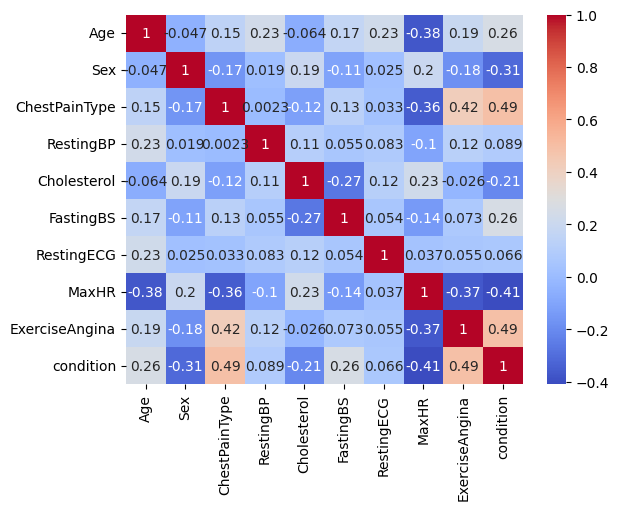

In [ ]:
# Plot the heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [ ]:
data.condition.value_counts()

1    416
0    318
Name: condition, dtype: int64

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n", data.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
condition         0
dtype: int64


In [5]:
# Splitting the data into training and testing sets
X = data.drop(columns=['condition'])
y = data['condition']

## Stacked Generalization

### Base Model

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

# Define the base models
base_models = [
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier())
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to keep track of best metrics
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the stacking model
    stacking_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = stacking_model.predict(X_val)

    # Calculate metrics on validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold

# Print the best metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Accuracy: {:.2%}".format(best_accuracy))
print("Precision: {:.2%}".format(best_precision))
print("Recall: {:.2%}".format(best_recall))
print("Specificity: {:.2%}".format(best_specificity))
print("F1 Score: {:.2%}".format(best_f1))

# Save the best model as a .pkl file
joblib.dump(stacking_model, 'Best_Stacking_Model_Default.pkl')

Best Metrics from Fold 3
Accuracy: 88.44%
Precision: 87.21%
Recall: 92.59%
Specificity: 83.33%
F1 Score: 89.82%


['Best_Stacking_Model_Default.pkl']

### Hyperparameter Tuning

In [9]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

# Define the base models
base_models = [
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier())
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define the parameter grid
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'final_estimator__solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(stacking_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the data
grid_search.fit(X, y)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'Best_Stacking_Model_Tuning.pkl')

# Initialize variables to keep track of best metrics and fold
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the best model
    best_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = best_model.predict(X_val)

    # Calculate metrics on validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold

# Print the highest metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Highest Accuracy: {:.2%}".format(best_accuracy))
print("Highest Precision: {:.2%}".format(best_precision))
print("Highest Recall: {:.2%}".format(best_recall))
print("Highest Specificity: {:.2%}".format(best_specificity))
print("Highest F1 Score: {:.2%}".format(best_f1))

Best Metrics from Fold 4
Highest Accuracy: 89.80%
Highest Precision: 86.32%
Highest Recall: 97.62%
Highest Specificity: 79.37%
Highest F1 Score: 91.62%


# Boosting
Base-model yang digunakan adalah Decision Tree

## Gradient Boosting Machines (GBM)

### Base Model

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# Create the Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to keep track of best metrics and fold
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0
best_model = None

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model
    gbm_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = gbm_model.predict(X_val)

    # Calculate metrics on the validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold
        best_model = gbm_model

# Print the highest metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Highest Accuracy: {:.2%}".format(best_accuracy))
print("Highest Precision: {:.2%}".format(best_precision))
print("Highest Recall: {:.2%}".format(best_recall))
print("Highest Specificity: {:.2%}".format(best_specificity))
print("Highest F1 Score: {:.2%}".format(best_f1))

# Save the best model as a .pkl file
if best_model:
    joblib.dump(best_model, 'Best_Gradient_Boosting_Model_Default.pkl')

Best Metrics from Fold 4
Highest Accuracy: 89.80%
Highest Precision: 88.76%
Highest Recall: 94.05%
Highest Specificity: 84.13%
Highest F1 Score: 91.33%


### Tuning GBM

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# Create the Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to keep track of best metrics and fold
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0
best_model = None

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create the GridSearchCV object
    grid_search = GridSearchCV(gbm_model, param_grid=param_grid, cv=skf, scoring='accuracy')

    # Fit the GridSearchCV object on the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best model and its hyperparameters
    best_model = grid_search.best_estimator_

    # Train the best model
    best_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = best_model.predict(X_val)

    # Calculate metrics on validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold
        best_model = best_model

# Print the highest metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Highest Accuracy: {:.2%}".format(best_accuracy))
print("Highest Precision: {:.2%}".format(best_precision))
print("Highest Recall: {:.2%}".format(best_recall))
print("Highest Specificity: {:.2%}".format(best_specificity))
print("Highest F1 Score: {:.2%}".format(best_f1))

# Save the best model as a .pkl file
if best_model:
    joblib.dump(best_model, 'Best_Gradient_Boosting_Model_Tuning.pkl')

Best Metrics from Fold 4
Highest Accuracy: 89.12%
Highest Precision: 88.64%
Highest Recall: 92.86%
Highest Specificity: 84.13%
Highest F1 Score: 90.70%


# Bagging
Base-model yang digunakan adalah Decision Tree

## Random Forest

### Base Model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

# Create the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to keep track of best metrics and fold
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0
best_model = None

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model
    random_forest_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = random_forest_model.predict(X_val)

    # Calculate metrics on validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold
        best_model = random_forest_model

# Print the highest metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Highest Accuracy: {:.2%}".format(best_accuracy))
print("Highest Precision: {:.2%}".format(best_precision))
print("Highest Recall: {:.2%}".format(best_recall))
print("Highest Specificity: {:.2%}".format(best_specificity))
print("Highest F1 Score: {:.2%}".format(best_f1))

# Save the best model as a .pkl file
if best_model:
    joblib.dump(best_model, 'Best_Random_Forest_Model_Default.pkl')

Best Metrics from Fold 4
Highest Accuracy: 88.44%
Highest Precision: 88.51%
Highest Recall: 91.67%
Highest Specificity: 84.13%
Highest F1 Score: 90.06%


### Tuning RF

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

# Create the base Decision Tree model
base_model = DecisionTreeClassifier()

# Create the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to keep track of best metrics and fold
best_accuracy = 0
best_precision = 0
best_specificity = 0
best_recall = 0
best_f1 = 0
best_fold = 0
best_model = None

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create the GridSearchCV object
    grid_search = GridSearchCV(random_forest_model, param_grid=param_grid, cv=skf, scoring='accuracy')

    # Fit the GridSearchCV object on the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best model
    best_fold_model = grid_search.best_estimator_

    # Train the best model
    best_fold_model.fit(X_train, y_train)

    # Make predictions on the validation set
    predictions = best_fold_model.predict(X_val)

    # Calculate metrics on validation set
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    confusion = confusion_matrix(y_val, predictions)

    # Calculate specificity
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn + fp)

    # Check if current fold's metrics are better than previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_precision = precision
        best_specificity = specificity
        best_recall = recall
        best_f1 = f1
        best_fold = fold
        best_model = best_fold_model

# Print the highest metrics and corresponding fold
print("Best Metrics from Fold", best_fold)
print("Highest Accuracy: {:.2%}".format(best_accuracy))
print("Highest Precision: {:.2%}".format(best_precision))
print("Highest Recall: {:.2%}".format(best_recall))
print("Highest Specificity: {:.2%}".format(best_specificity))
print("Highest F1 Score: {:.2%}".format(best_f1))

# Save the best model as a .pkl file
if best_model:
    joblib.dump(best_model, 'Best_Random_Forest_Model_Tuning.pkl')

Best Metrics from Fold 4
Highest Accuracy: 89.80%
Highest Precision: 88.76%
Highest Recall: 94.05%
Highest Specificity: 84.13%
Highest F1 Score: 91.33%
